<a href="https://colab.research.google.com/github/Shashank1202/NLP-Transformers/blob/main/BERT_Model_For_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
import pandas as pd

df = pd.read_csv("spam.csv", encoding='latin-1')
df.head(5)

In [ ]:
df=df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [ ]:
df.head()

In [ ]:
df.groupby('v1').describe()

In [ ]:
df['v1'].value_counts()

In [ ]:
df_spam = df[df['v1']=='spam']
df_spam.shape

In [ ]:
df_ham = df[df['v1']=='ham']
df_ham.shape

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

In [ ]:
df_balanced['v1'].value_counts()

In [ ]:
df_balanced['spam']=df_balanced['v1'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['v2'],df_balanced['spam'], stratify=df_balanced['spam'])

In [ ]:
X_train.head(4)

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

In [ ]:
len(X_train)

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 333s 9s/step - loss: 0.6166 - accuracy: 0.6625 - precision: 0.6564 - recall: 0.6821
Epoch 2/10
35/35 [==============================] - 337s 10s/step - loss: 0.5008 - accuracy: 0.8268 - precision: 0.8492 - recall: 0.7946
Epoch 3/10
35/35 [==============================] - 339s 10s/step - loss: 0.4503 - accuracy: 0.8241 - precision: 0.8061 - recall: 0.8536
Epoch 4/10
35/35 [==============================] - 341s 10s/step - loss: 0.4033 - accuracy: 0.8679 - precision: 0.8692 - recall: 0.8661
Epoch 5/10
35/35 [==============================] - 336s 10s/step - loss: 0.3682 - accuracy: 0.8839 - precision: 0.8669 - recall: 0.9071
Epoch 6/10
35/35 [==============================] - 336s 10s/step - loss: 0.3489 - accuracy: 0.8813 - precision: 0.8792 - recall: 0.8839
Epoch 7/10
35/35 [==============================] - 339s 10s/step - loss: 0.3263 - accuracy: 0.8955 - precision: 0.8773 - recall: 0.9196
Epoch 8/10
35/35 [========================

In [25]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 113s 9s/step - loss: 0.2811 - accuracy: 0.9198 - precision: 0.9198 - recall: 0.9198


[0.2811303734779358,
 0.9197860956192017,
 0.9197860956192017,
 0.9197860956192017]

In [26]:
y_pred= model.predict(X_test)
y_pred= y_pred.flatten()

12/12 [==============================] - 112s 9s/step


In [ ]:
import numpy as np

y_predicted = np.where(y_pred > 0.5, 1, 0)
y_predicted

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[172,  15],
       [ 15, 172]])

Text(50.722222222222214, 0.5, 'Truth')

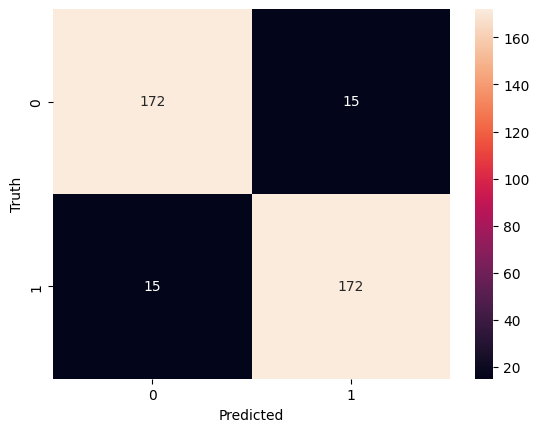

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [30]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       187
           1       0.92      0.92      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



In [31]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.7538083 ],
       [0.78338   ],
       [0.7257618 ],
       [0.18277639],
       [0.07792904]], dtype=float32)